In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dense, Dropout
from PIL import Image,ImageOps,ImageEnhance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau
import os

In [2]:
le = LabelEncoder()

In [3]:
def rotate(img,angle):
    return img.rotate(angle=angle)

def flip(img):
    return ImageOps.mirror(img)

def change_brightness(img,factor = 1.2):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

In [4]:
data = []
result = []
labels = []
le = LabelEncoder()
le.fit(['paper', 'rock', 'scissors'])

for hand in ['paper', 'rock', 'scissors']:
    label = hand
    class_index = le.transform([hand])[0]
    class_label = to_categorical(class_index, num_classes=3)

    paths = []
    for r, d, f in os.walk(os.path.join(r"C:\\Users\\USER\\Desktop\\rock paper scissors\\dataset\\train", hand)):
        for file in f:
            if file.lower().endswith(".png"):
                paths.append(os.path.join(r, file))

    # Move this outside the inner loop
    for path in paths:
        img = Image.open(path).convert('RGB').resize((64, 64))
        img = np.array(img).astype('float32') / 255.0
        if img.shape == (64, 64, 3):
            data.append(img)
            labels.append(label)

le1 = LabelEncoder()
encoded = le1.fit_transform(labels)
result = to_categorical(encoded, num_classes=3)

data = np.array(data)
result = np.array(result)

print('Data shape:', data.shape)
print('Result shape:', result.shape)


Data shape: (3912, 64, 64, 3)
Result shape: (3912, 3)


In [5]:
from sklearn.utils import shuffle
data, result = shuffle(data, result, random_state=42)

In [6]:
result = result.reshape(-1, 3)
result.shape

(3912, 3)

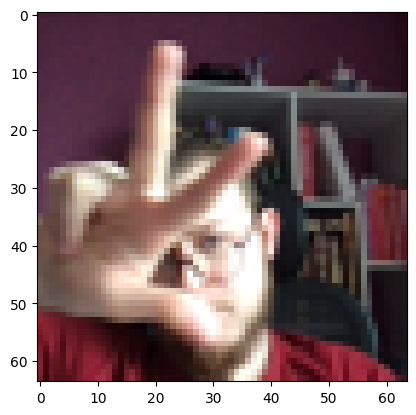

In [7]:
plt.imshow(data[4])

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(data, result, test_size=0.2, random_state=42,stratify=result)

In [9]:
import collections

flat_y = np.ravel(ytrain)

print("Class distribution in training set:")
print(collections.Counter(flat_y))

Class distribution in training set:
Counter({0.0: 6258, 1.0: 3129})


In [10]:
print("Train:", np.sum(ytrain, axis=0))
print("Test:", np.sum(ytest, axis=0))

Train: [1061. 1034. 1034.]
Test: [265. 259. 259.]


In [11]:
print("ytrain shape:", ytrain.shape)
print("First 5 ytrain values:\n", ytrain[:5])

ytrain shape: (3129, 3)
First 5 ytrain values:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [12]:
print(ytrain[0])

[1. 0. 0.]


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot to label indices
y_train_labels = np.argmax(ytrain, axis=1)

# Compute weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)


Class weights: {0: 0.9830348727615457, 1: 1.0087040618955512, 2: 1.0087040618955512}


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers

model = Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same',input_shape=(64,64,3))) 
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16,(3,3),activation='relu',padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(32, (3, 3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3),activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3),activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3),activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax')) 



c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             

 Total params: 278,227 (1.06 MB)

 Trainable params: 277,875 (1.06 MB)

 Non-trainable params: 352 (1.38 KB)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '../dataset/train',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)


Found 3912 images belonging to 3 classes.


In [17]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '../dataset/val',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 804 images belonging to 3 classes.


In [27]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

In [28]:
print("ytrain shape:", ytrain.shape)  # Should be (num_samples, 3)
print(ytrain[:5])  # Should look like [0 1 0], etc.


ytrain shape: (3129, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [29]:
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  
    monitor='val_loss',         
    save_best_only=True,        
    verbose=1
)

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [32]:
print("xtrain shape:", xtrain.shape)
print("ytrain shape:", ytrain.shape)


xtrain shape: (3129, 64, 64, 3)
ytrain shape: (3129, 3)


In [33]:
model.fit(
    train_generator,
    validation_data=(xtest, ytest),
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stop, reduce_lr],
    shuffle=True
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.4668 - loss: 1.0136
Epoch 1: val_loss improved from inf to 1.54511, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.4684 - loss: 1.0120 - val_accuracy: 0.3308 - val_loss: 1.5451 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7370 - loss: 0.7210
Epoch 2: val_loss did not improve from 1.54511
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.7373 - loss: 0.7205 - val_accuracy: 0.3308 - val_loss: 2.0392 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8029 - loss: 0.6123
Epoch 3: val_loss improved from 1.54511 to 1.40453, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.8030 - loss: 0.6121 - val_accuracy: 0.3308 - val_loss: 1.4045 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8260 - loss: 0.5835
Epoch 4: val_loss improved from 1.40453 to 0.93695, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.8260 - loss: 0.5835 - val_accuracy: 0.4879 - val_loss: 0.9369 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8345 - loss: 0.5698
Epoch 5: val_loss did not improve from 0.93695
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.8345 - loss: 0.5698 - val_accuracy: 0.4955 - val_loss: 1.0612 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8409 - loss: 0.5550
Epoch 6: val_loss improved from 0.93695 to 0.62298, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.8411 - loss: 0.5549 - val_accuracy: 0.7739 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8611 - loss: 0.5454
Epoch 7: val_loss did not improve from 0.62298
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.8612 - loss: 0.5453 - val_accuracy: 0.7995 - val_loss: 0.6302 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8754 - loss: 0.5228
Epoch 8: val_loss improved from 0.62298 to 0.45759, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.8756 - loss: 0.5227 - val_accuracy: 0.8978 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8998 - loss: 0.5001
Epoch 9: val_loss did not improve from 0.45759
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.8998 - loss: 0.5001 - val_accuracy: 0.8442 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9079 - loss: 0.4846
Epoch 10: val_loss did not improve from 0.45759
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.9079 - loss: 0.4847 - val_accuracy: 0.8940 - val_loss: 0.4968 - learning_rate: 0.0010
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9049 - loss: 0.4786
Epoch 11: val_loss did not improve from 0.45759

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.9051 - loss: 0.4784 - val_accuracy

62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 274ms/step - accuracy: 0.9286 - loss: 0.4492 - val_accuracy: 0.9246 - val_loss: 0.4359 - learning_rate: 5.0000e-04
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9382 - loss: 0.4347
Epoch 13: val_loss improved from 0.43591 to 0.40079, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.9382 - loss: 0.4348 - val_accuracy: 0.9502 - val_loss: 0.4008 - learning_rate: 5.0000e-04
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9442 - loss: 0.4277
Epoch 14: val_loss improved from 0.40079 to 0.39687, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.9442 - loss: 0.4277 - val_accuracy: 0.9425 - val_loss: 0.3969 - learning_rate: 5.0000e-04
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9489 - loss: 0.4207
Epoch 15: val_loss improved from 0.39687 to 0.36688, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.9489 - loss: 0.4207 - val_accuracy: 0.9706 - val_loss: 0.3669 - learning_rate: 5.0000e-04
Epoch 16/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9443 - loss: 0.4166
Epoch 16: val_loss did not improve from 0.36688
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.9444 - loss: 0.4166 - val_accuracy: 0.9489 - val_loss: 0.3859 - learning_rate: 5.0000e-04
Epoch 17/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9583 - loss: 0.4108
Epoch 17: val_loss did not improve from 0.36688
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - accuracy: 0.9583 - loss: 0.4108 - val_accuracy: 0.9515 - val_loss: 0.3763 - learning_rate: 5.0000e-04
Epoch 18/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9571 - loss: 0.4069
Epoch 18: val_loss did not improve from 0.36688

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.9571 - loss: 0.4069 

62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - accuracy: 0.9620 - loss: 0.3979 - val_accuracy: 0.9732 - val_loss: 0.3467 - learning_rate: 2.5000e-04
Epoch 21/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9722 - loss: 0.3864
Epoch 21: val_loss did not improve from 0.34668
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - accuracy: 0.9722 - loss: 0.3864 - val_accuracy: 0.9706 - val_loss: 0.3516 - learning_rate: 2.5000e-04
Epoch 22/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9673 - loss: 0.3855
Epoch 22: val_loss improved from 0.34668 to 0.34043, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.9673 - loss: 0.3855 - val_accuracy: 0.9783 - val_loss: 0.3404 - learning_rate: 2.5000e-04
Epoch 23/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9735 - loss: 0.3875
Epoch 23: val_loss did not improve from 0.34043
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.9735 - loss: 0.3875 - val_accuracy: 0.9566 - val_loss: 0.3659 - learning_rate: 2.5000e-04
Epoch 24/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9664 - loss: 0.3906
Epoch 24: val_loss did not improve from 0.34043
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.9665 - loss: 0.3905 - val_accuracy: 0.9489 - val_loss: 0.3789 - learning_rate: 2.5000e-04
Epoch 25/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9674 - loss: 0.3928
Epoch 25: val_loss did not improve from 0.34043

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.9675 - loss: 0.3927 

62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.9773 - loss: 0.3742 - val_accuracy: 0.9796 - val_loss: 0.3374 - learning_rate: 1.2500e-04
Epoch 28/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9871 - loss: 0.3617
Epoch 28: val_loss improved from 0.33739 to 0.33603, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.9870 - loss: 0.3618 - val_accuracy: 0.9783 - val_loss: 0.3360 - learning_rate: 1.2500e-04
Epoch 29/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9735 - loss: 0.3775
Epoch 29: val_loss did not improve from 0.33603
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.9736 - loss: 0.3774 - val_accuracy: 0.9668 - val_loss: 0.3533 - learning_rate: 1.2500e-04
Epoch 30/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9870 - loss: 0.3632
Epoch 30: val_loss improved from 0.33603 to 0.33324, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.9869 - loss: 0.3633 - val_accuracy: 0.9796 - val_loss: 0.3332 - learning_rate: 1.2500e-04
Epoch 31/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9770 - loss: 0.3708
Epoch 31: val_loss did not improve from 0.33324
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - accuracy: 0.9771 - loss: 0.3707 - val_accuracy: 0.9757 - val_loss: 0.3410 - learning_rate: 1.2500e-04
Epoch 32/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9881 - loss: 0.3616
Epoch 32: val_loss improved from 0.33324 to 0.32993, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.9881 - loss: 0.3616 - val_accuracy: 0.9821 - val_loss: 0.3299 - learning_rate: 1.2500e-04
Epoch 33/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9771 - loss: 0.3666
Epoch 33: val_loss improved from 0.32993 to 0.32914, saving model to best_model.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.9771 - loss: 0.3666 - val_accuracy: 0.9821 - val_loss: 0.3291 - learning_rate: 1.2500e-04
Epoch 34/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9838 - loss: 0.3685
Epoch 34: val_loss did not improve from 0.32914
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.9837 - loss: 0.3685 - val_accuracy: 0.9783 - val_loss: 0.3391 - learning_rate: 1.2500e-04
Epoch 35/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9816 - loss: 0.3664
Epoch 35: val_loss did not improve from 0.32914
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.9816 - loss: 0.3664 - val_accuracy: 0.9783 - val_loss: 0.3387 - learning_rate: 1.2500e-04
Epoch 36/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9798 - loss: 0.3699
Epoch 36: val_loss did not improve from 0.32914

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.9798 - loss: 0.3699 -

In [35]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluate on test set
loss, acc = model.evaluate(xtest, ytest, verbose=1)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(xtest)

# Convert one-hot to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(ytest, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9865 - loss: 0.3309
Test Accuracy: 0.9821
Test Loss: 0.3299
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       265
           1       0.98      0.98      0.98       259
           2       1.00      0.97      0.98       259

    accuracy                           0.98       783
   macro avg       0.98      0.98      0.98       783
weighted avg       0.98      0.98      0.98       783



In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Optional: Load best weights
model.load_weights('best_model.h5')

# Step 1: Recompile with a lower learning rate
fine_tune_lr = 1e-4  # Or 5e-5
model.compile(
    optimizer=Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 2: Set up callbacks (reusing if already defined)
checkpoint = ModelCheckpoint("finetuned_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Step 3: Fit again with fewer epochs
history_finetune = model.fit(
    train_generator,
    validation_data=(xtest, ytest),
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr],
    shuffle=True
)


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 688ms/step - accuracy: 0.9849 - loss: 0.0947 - val_accuracy: 0.9745 - val_loss: 0.0604 - learning_rate: 1.0000e-04
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.9799 - loss: 0.0700 - val_accuracy: 0.9770 - val_loss: 0.0537 - learning_rate: 1.0000e-04
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.9816 - loss: 0.0622 - val_accuracy: 0.9770 - val_loss: 0.0541 - learning_rate: 1.0000e-04
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.9832 - loss: 0.0533 - val_accuracy: 0.9745 - val_loss: 0.0590 - learning_rate: 1.0000e-04
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.9841 - loss: 0.0571 - val_accuracy: 0.9757 - val_loss: 0.0534 - learning_rate: 5.0000e-05
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.9872 - loss: 0.0490 - val_accuracy: 0.9821 - val_loss: 0.0484 - learning_rate: 5.0000e-05
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - acc

In [38]:
model.load_weights("finetuned_model.keras")

loss, acc = model.evaluate(xtest, ytest)
print(f"Fine-tuned Test Accuracy: {acc:.4f}")
print(f"Fine-tuned Test Loss: {loss:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9844 - loss: 0.0395
Fine-tuned Test Accuracy: 0.9821
Fine-tuned Test Loss: 0.0402


In [39]:
model.save("rps_model.h5")